In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"  # or torch, or tensorflow

import pandas as pd
import keras
from keras import layers

In [3]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

In [4]:
dataframe.shape

(303, 14)

In [5]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    f"Using {len(train_dataframe)} samples for training "
    f"and {len(val_dataframe)} for validation"
)

Using 242 samples for training and 61 for validation


In [6]:
COLUMN_NAMES = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "target",
]
# Target feature name.
TARGET_FEATURE_NAME = "target"
# Numeric feature names.
NUMERIC_FEATURE_NAMES = ["age", "trestbps", "thalach", "oldpeak", "slope", "chol"]
# Categorical features and their vocabulary lists.
# Note that we add 'v=' as a prefix to all categorical feature values to make
# sure that they are treated as strings.

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name: sorted(
        [
            # Integer categorcal must be int and string must be str
            value if dataframe[feature_name].dtype == "int64" else str(value)
            for value in list(dataframe[feature_name].unique())
        ]
    )
    for feature_name in COLUMN_NAMES
    if feature_name not in list(NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME])
}
# All features names.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + list(
    CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()
)

In [7]:
# Tensorflow required for tf.data.Dataset
import tensorflow as tf


# We process our datasets elements here (categorical) and convert them to indices to avoid this step
# during model training since only tensorflow support strings.
def encode_categorical(features, target):
    for feature_name in features:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            lookup_class = (
                layers.StringLookup
                if features[feature_name].dtype == "string"
                else layers.IntegerLookup
            )
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = lookup_class(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="binary",
            )
            # Convert the string input values into integer indices.
            value_index = index(features[feature_name])
            features[feature_name] = value_index

        else:
            pass

    # Change features from OrderedDict to Dict to match Inputs as they are Dict.
    return dict(features), target


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    # Learn the statistics of the data
    normalizer.adapt(feature_ds)
    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

2025-11-06 19:23:23.575991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)).map(
        encode_categorical
    )
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

2025-11-06 19:23:24.696305: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1762453404.697279   16581 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9037 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [9]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=51>, 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, 'cp': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 1])>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=130>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=305>, 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, 'restecg': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 0, 0])>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=142>, 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.2>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'ca': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 0, 0, 0])>, 'thal': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 1])>}
Target: tf.Tensor(1, shape=(), dtype=int64)


2025-11-06 19:23:25.006357: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [11]:
# Categorical features have different shapes after the encoding, dependent on the
# vocabulary or unique values of each feature. We create them accordinly to match the
# input data elements generated by tf.data.Dataset after pre-processing them
def create_model_inputs():
    inputs = {}

    # This a helper function for creating categorical features
    def create_input_helper(feature_name):
        num_categories = len(CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name])
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(num_categories,), dtype="int64"
        )
        return inputs

    for feature_name in FEATURE_NAMES:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            # Categorical features
            create_input_helper(feature_name)
        else:
            # Make them float32, they are Real numbers
            feature_input = layers.Input(name=feature_name, shape=(1,), dtype="float32")
            # Process the Inputs here
            inputs[feature_name] = encode_numerical_feature(
                feature_input, feature_name, train_ds
            )
    return inputs


# This Layer defines the logic of the Model to perform the classification
class Classifier(keras.layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = layers.Dense(32, activation="relu")
        self.dropout = layers.Dropout(0.5)
        self.dense_2 = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        all_features = layers.concatenate(list(inputs.values()))
        x = self.dense_1(all_features)
        x = self.dropout(x)
        output = self.dense_2(x)
        return output

    # Surpress build warnings
    def build(self, input_shape):
        self.built = True


# Create the Classifier model
def create_model():
    all_inputs = create_model_inputs()
    output = Classifier()(all_inputs)
    model = keras.Model(all_inputs, output)
    return model


model = create_model()
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

2025-11-06 19:23:25.176084: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-06 19:23:25.331885: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/xy/Desktop/ml/tf_2.20/tf_2.20/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'age' mapping to value <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'age' (via `Input(..., name='age')`)
  warnings.warn(
/home/xy/Desktop/ml/tf_2.20/tf_2.20/lib/python3.10/site-packages/keras/src/models/functional.py:107: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 

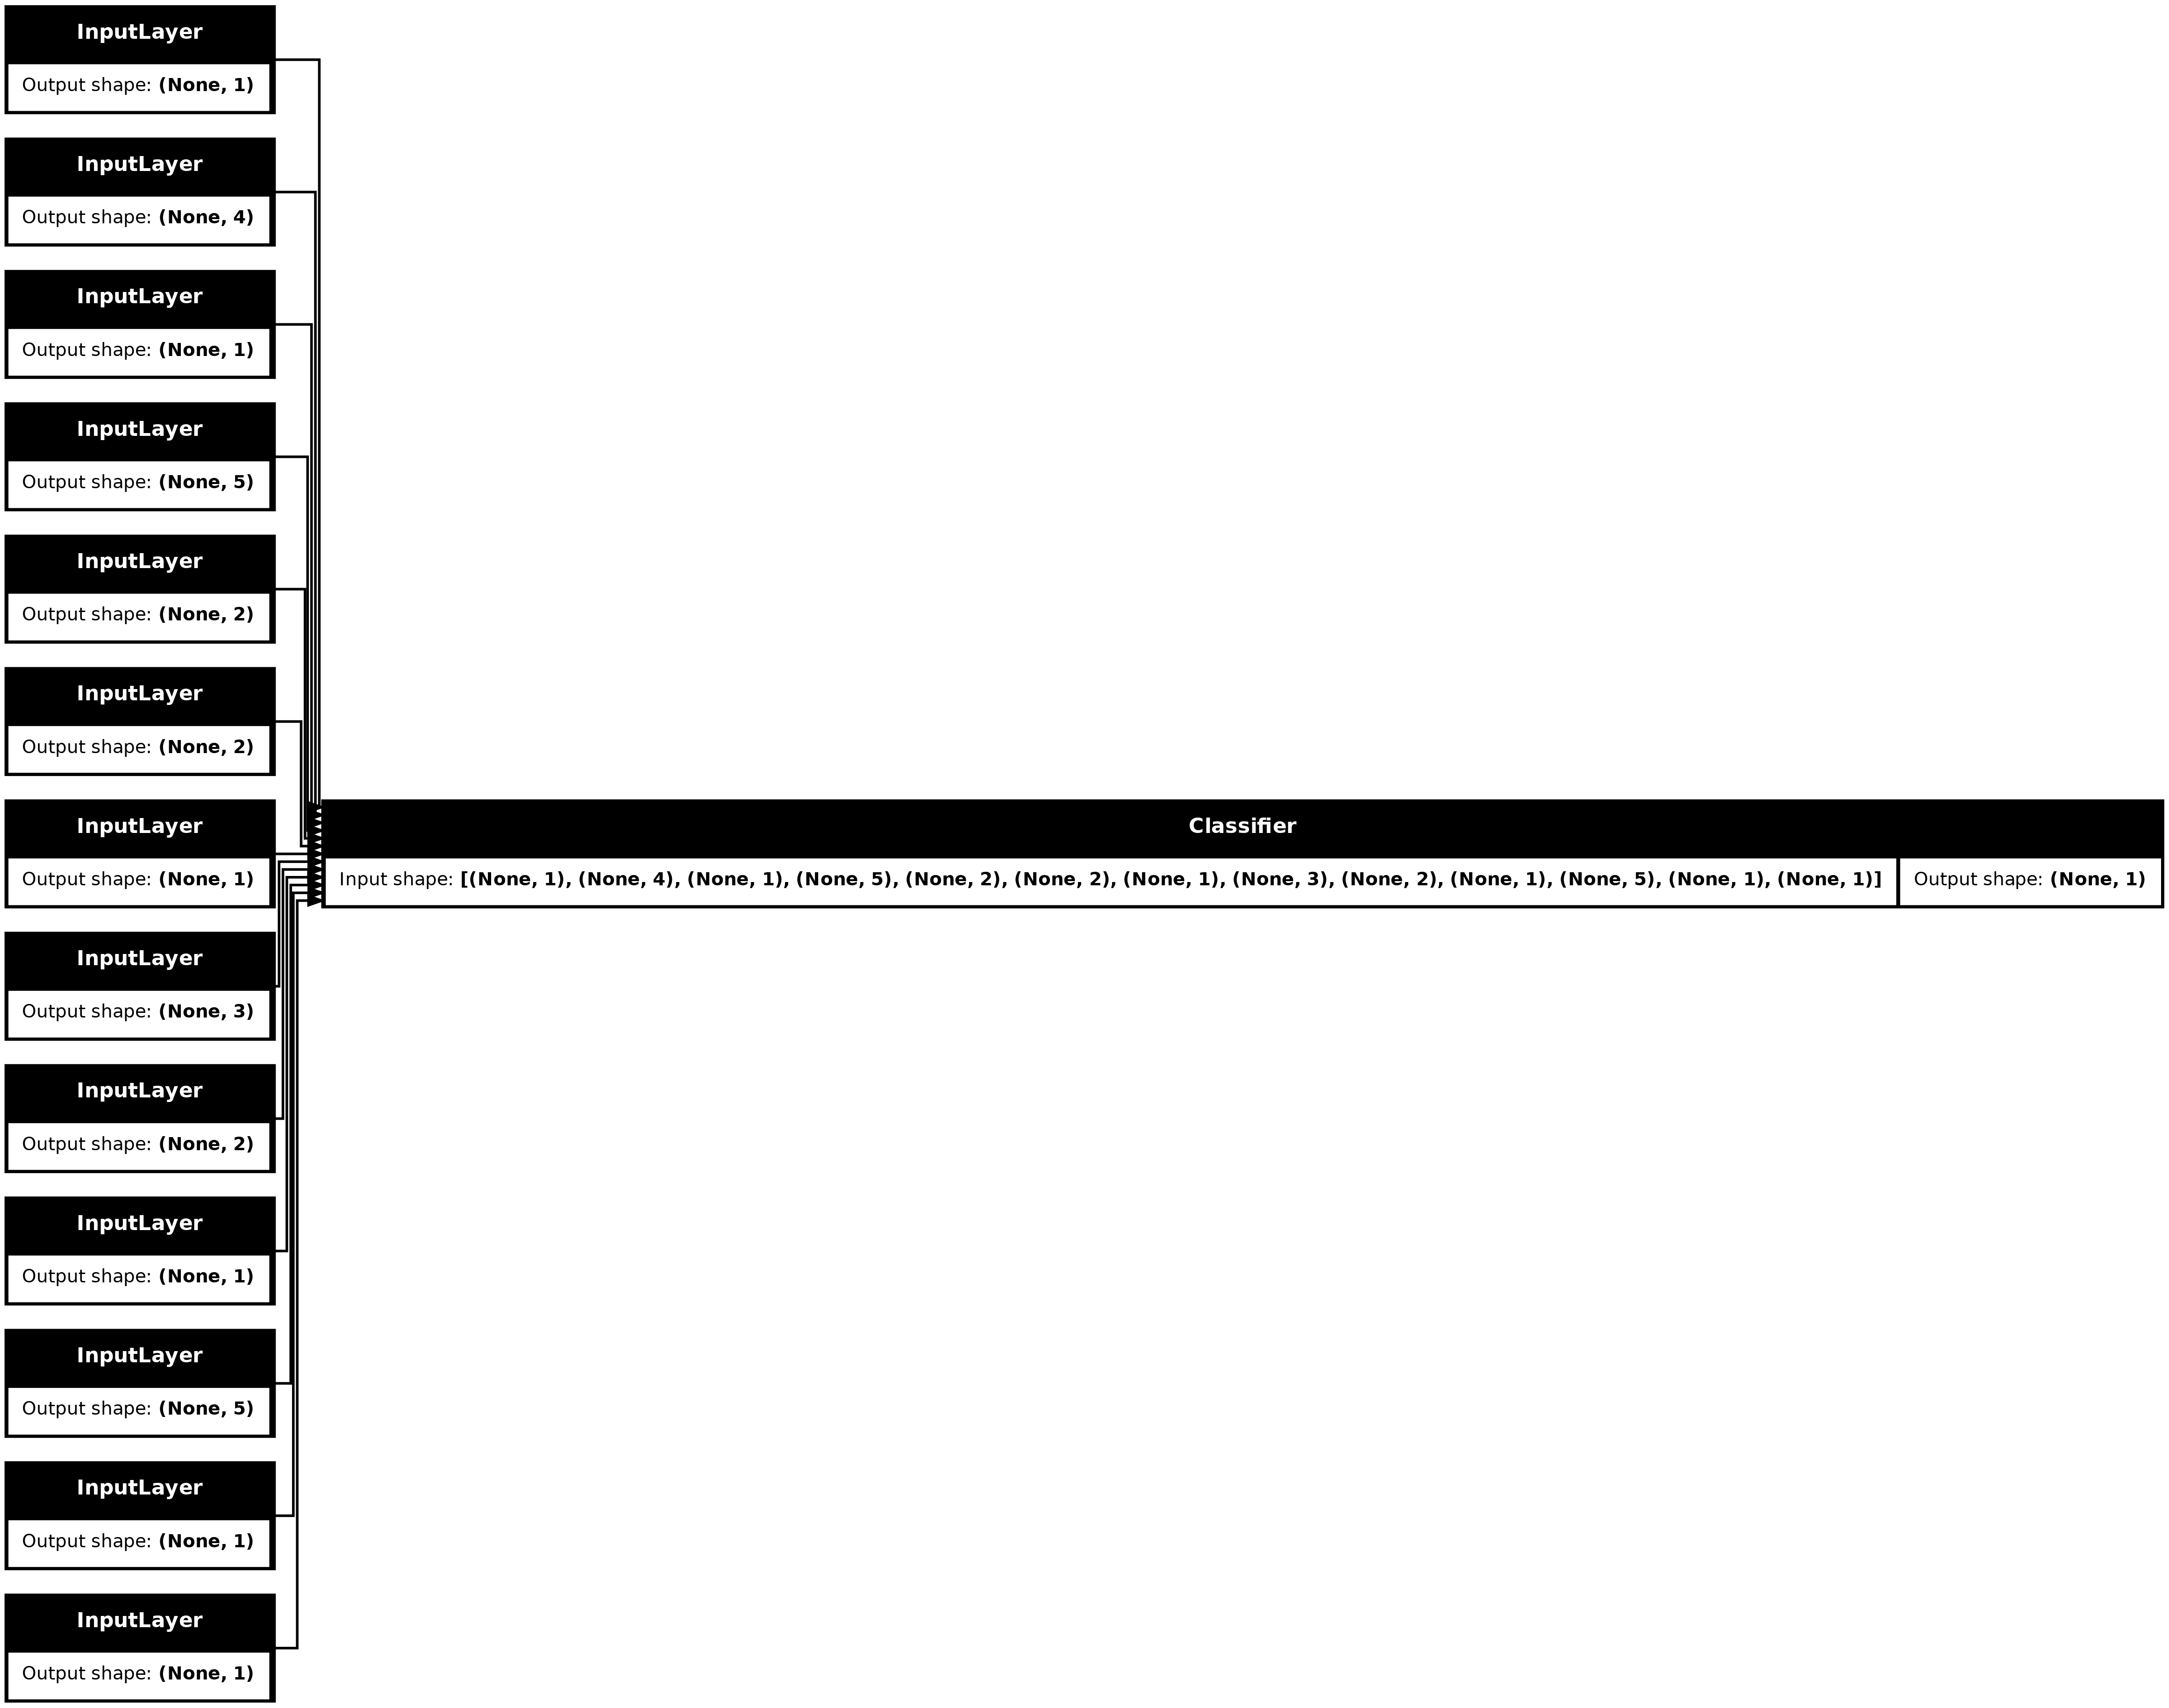

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [13]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6694 - loss: 5.0779 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6983 - loss: 4.7748 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6777 - loss: 4.9362 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7025 - loss: 4.6870 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7025 - loss: 4.7248 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6901 - loss: 4.6660 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6983 - loss: 4.6005 - val_accuracy: 0.7705 - val_loss: 3.6992
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6777 - loss: 4.8128 - val_accuracy: 0.7705 - val_loss: 3.6992


In [14]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}


# Given the category (in the sample above - key) and the category value (in the sample above - value),
# we return its one-hot encoding
def get_cat_encoding(cat, cat_value):
    # Create a list of zeros with the same length as categories
    encoding = [0] * len(cat)
    # Find the index of category_value in categories and set the corresponding position to 1
    if cat_value in cat:
        encoding[cat.index(cat_value)] = 1
    return encoding


for name, value in sample.items():
    if name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
        sample.update(
            {
                name: get_cat_encoding(
                    CATEGORICAL_FEATURES_WITH_VOCABULARY[name], sample[name]
                )
            }
        )
# Convert inputs to tensors
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"This particular patient had a {100 * predictions[0][0]:.1f} "
    "percent probability of having a heart disease, "
    "as evaluated by our model."
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This particular patient had a 0.0 percent probability of having a heart disease, as evaluated by our model.
